In [1]:
#Importing necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import warnings
warnings.simplefilter('ignore')
import mplfinance as mpf
from pandas.plotting import lag_plot
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Downloading the stock data
start = '2015-01-01'
end = '2020-07-30'
ticker = 'JNJ'
interval = "1d"
df =yf.download(ticker,start,end,interval)


[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculating the stock return
df['Return'] =100*df['Adj Close'].pct_change()
df.drop(['Dividends','Stock Splits'],axis=1,inplace=True)
df.dropna(inplace=True)

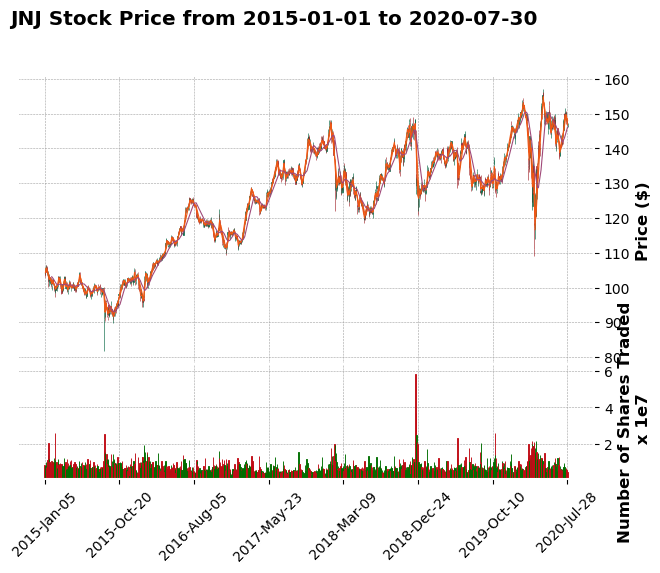

In [4]:
# Visualizing the stock price and volume

mpf.plot(df, type='candle', style='charles',
            title=ticker+' Stock Price from '+start+' to '+end ,
            ylabel='Price ($)',
            ylabel_lower='Number of Shares Traded',
            volume=True, 
            mav=(3,6,20), 
           )
plt.show()

In [5]:
# Information summary of the stock data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1402 entries, 2015-01-05 to 2020-07-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1402 non-null   float64
 1   High       1402 non-null   float64
 2   Low        1402 non-null   float64
 3   Close      1402 non-null   float64
 4   Adj Close  1402 non-null   float64
 5   Volume     1402 non-null   int64  
 6   Return     1402 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 87.6 KB


In [6]:
# Describtive statistical summary of stock data
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Return
count,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1.402000e+03,1402.000000
mean,124.466519,125.344643,123.552768,124.484194,114.740364,7.472988e+06,0.042402
std,15.892728,16.054849,15.741018,15.882112,18.896744,3.402752e+06,1.227700
min,90.699997,91.879997,81.790001,90.730003,78.699524,2.353800e+06,-10.037869
25%,112.797501,113.402502,112.272497,112.812502,100.079229,5.525175e+06,-0.444299
50%,127.994999,129.105003,126.925003,128.065002,119.406631,6.707000e+06,0.049306
75%,137.450005,138.547497,136.417500,137.312504,129.464581,8.503900e+06,0.597009
max,155.570007,157.000000,154.000000,155.509995,152.359604,5.814020e+07,7.997725


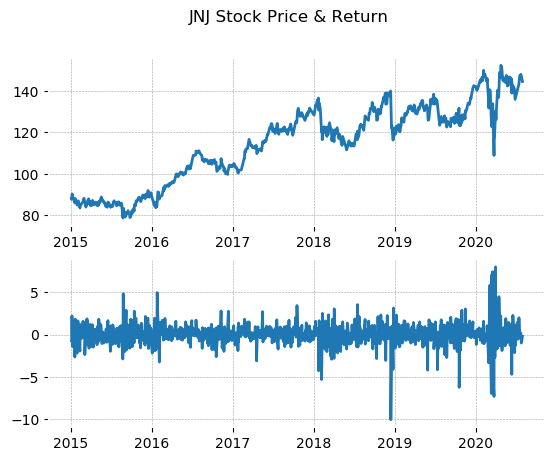

In [7]:
# Plotting Stock Price and Return
fig, axs = plt.subplots(2)
fig.suptitle(ticker+' Stock Price & Return')
axs[0].plot(df.index, df['Adj Close'])
axs[1].plot(df.index, df['Return'])
plt.show()

No handles with labels found to put in legend.


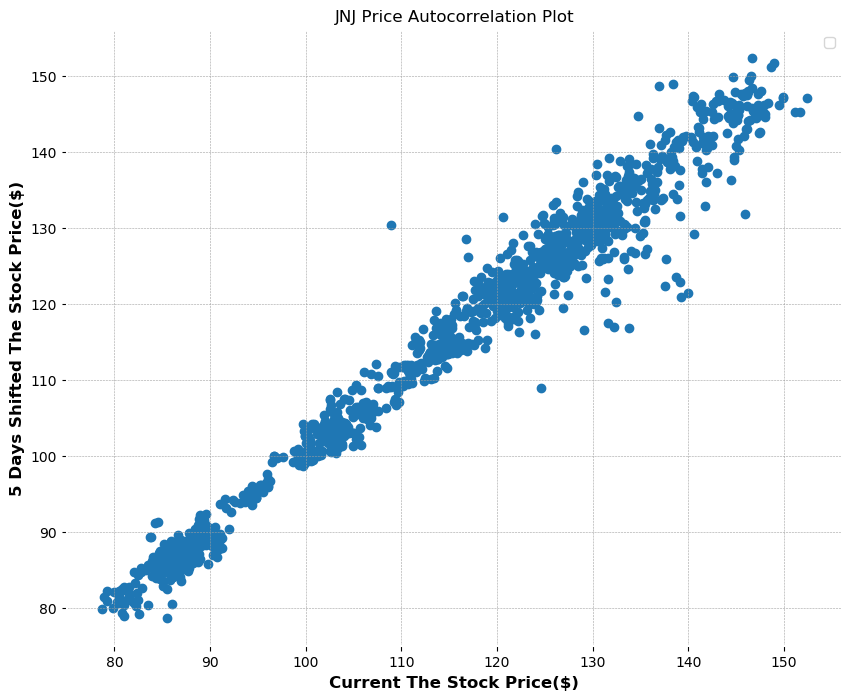

In [8]:
# The stock price's 5 days autocorrelation
plt.figure(figsize=(10,8))
lag_plot(df['Adj Close'], lag=5)
plt.title(ticker+' Price Autocorrelation Plot')
plt.xlabel('Current The Stock Price($)')
plt.ylabel('5 Days Shifted The Stock Price($)')
plt.grid(True)
plt.legend()
plt.show()

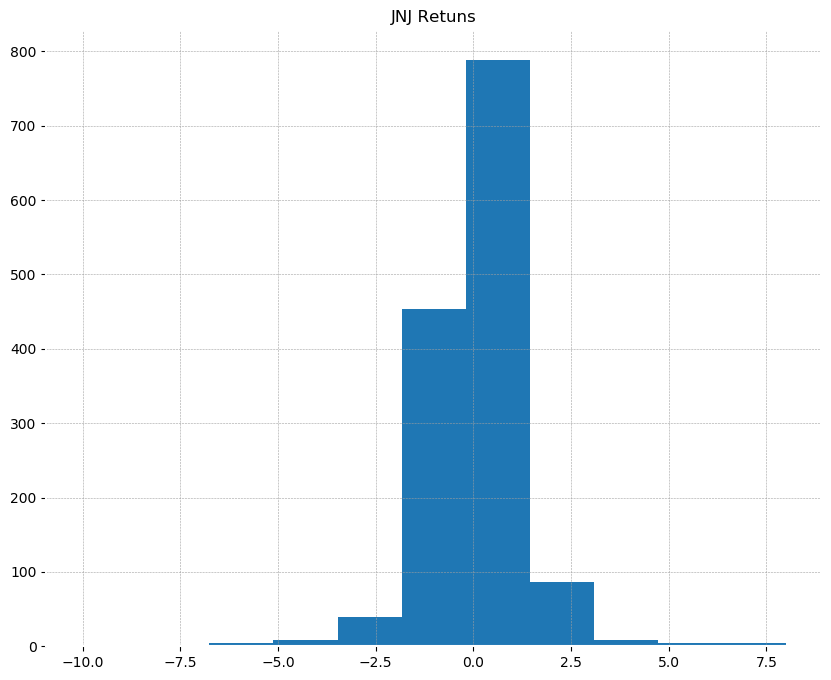

In [9]:
# Visualizing Distribution of Stock Returns
bins = int(round(1 + (3.322*np.log10(len(df)))))

fig= plt.figure(figsize=(10,8))
plt.hist(df['Return'].values,bins=bins)
plt.xlabel = 'Returns'
plt.ylabel = 'Frequency'
plt.title(ticker+' Retuns')
plt.show()

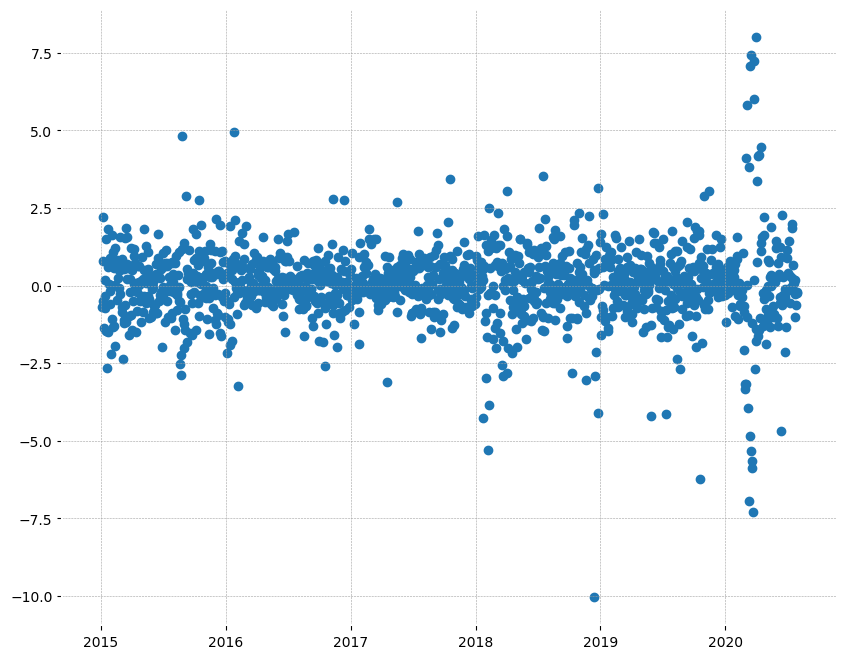

In [10]:
# The stock returns overtime
fig = plt.figure(figsize=(10,8))
plt.scatter(x=df.index,y=df['Return'].values)
plt.show()

In [11]:
# Garch Model Rolling Window Forecasting
split_date = '2020-02-07'
am = arch_model(df['Return'], vol='Garch', p=1, o=0, q=1, dist='skewt')
window = 120
index = df.index
start_loc = 0
end_loc = np.where(index>=split_date)[0].min()
forecasts = {}
for i in range(window):
    res = am.fit(first_obs=i + start_loc, last_obs=i + end_loc, disp='off')
    temp_result = res.forecast(horizon=1).variance


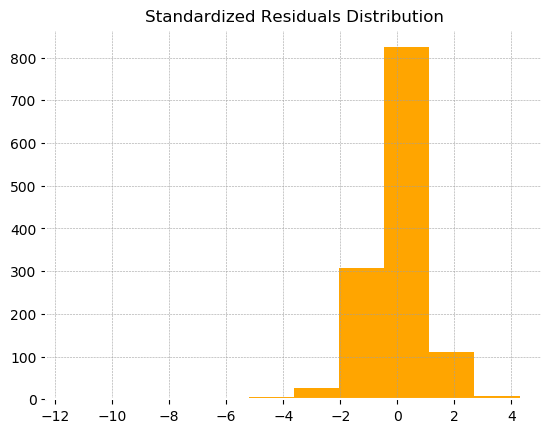

In [12]:
# Plotting Standardized Residuals Distribution
gm_resid = res.resid.dropna()
gm_std = res.conditional_volatility.dropna()
gm_std_resid = gm_resid /gm_std
plt.hist(gm_std_resid, facecolor = 'orange',label = 'standardized residuals',bins=10)
plt.title('Standardized Residuals Distribution')
plt.show()

In [13]:
#Printing the model summary
print(res.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                            Return   R-squared:                      -0.001
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                                 GARCH   Log-Likelihood:               -1750.49
Distribution:      Standardized Skew Student's t   AIC:                           3512.98
Method:                       Maximum Likelihood   BIC:                           3543.92
                                                   No. Observations:                 1282
Date:                           Thu, Jan 07 2021   Df Residuals:                     1276
Time:                                   12:42:11   Df Model:                            6
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [14]:
#Printing the model parameters and their P values
print(res.params)

print(res.pvalues)

mu          0.077333
omega       0.067441
alpha[1]    0.120399
beta[1]     0.833334
nu          3.864343
lambda      0.000067
Name: params, dtype: float64
mu           2.059308e-03
omega        7.090464e-04
alpha[1]     1.190531e-05
beta[1]     5.146009e-151
nu           1.121853e-16
lambda       9.985197e-01
Name: pvalues, dtype: float64


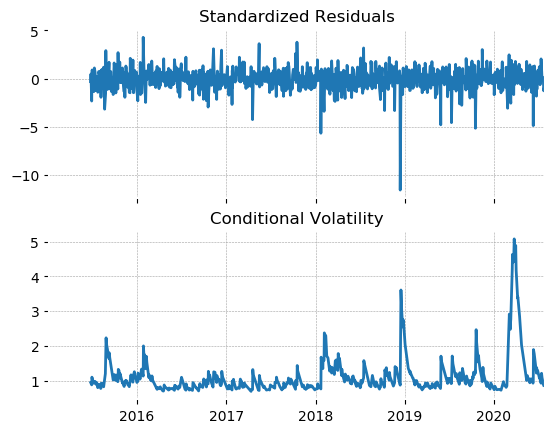

In [15]:
# Plotting Standardized Residuals & Conditional Volatility
res.plot()
plt.show()

In [16]:
# Diagnosting the model by performing the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)
if lb_test[1].min()>0.05:
    print(' All the p-values are larger than 5% so the null hypothesis cannot be rejected. In other words, no autocorrelations detected and the model is doing a decent job.')
else:
    print(' There is an autocorrelations detected and the model has problem.')

# Check p-values
print('P-values are: ', lb_test[1])


 All the p-values are larger than 5% so the null hypothesis cannot be rejected. In other words, no autocorrelations detected and the model is doing a decent job.
P-values are:  [0.69637226 0.60851381 0.80072627 0.4116346  0.42545908 0.55250617
 0.65833692 0.75574304 0.67125425 0.62817655]


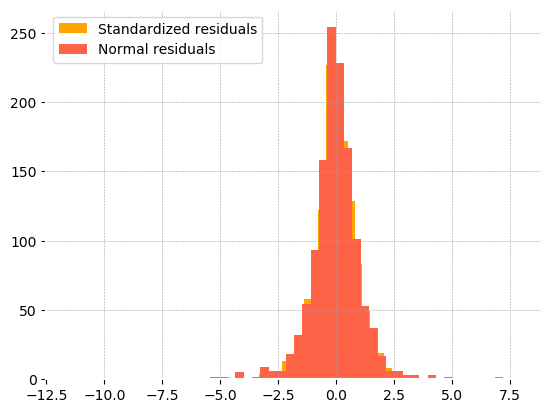

In [17]:
# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 50,facecolor = 'orange', label = 'Standardized residuals')
plt.hist(gm_resid, bins = 50,facecolor = 'tomato', label = 'Normal residuals')
plt.legend(loc = 'upper left')
plt.show()

In [18]:
# Goodness of fit
print('MAXIMUM LIKELIHOOD: ',res.loglikelihood)
print('AIC:' ,res.aic)
print('BIC: ',res.bic)


MAXIMUM LIKELIHOOD:  -1750.4913124396232
AIC: 3512.9826248792465
BIC:  3543.9196847041303


In [19]:
# Making forcast for variance
forecasts = res.forecast(horizon=1, start=split_date)
forecast_rolling_window = forecasts.variance[split_date:]

In [20]:
# Calculating realized volatility

df['log_price'] = np.log(df['Adj Close'])
df['log_return'] =100*(df['log_price'] - df['log_price'].shift(1))
df['squared_log_return'] = np.power(df['log_return'],2)
df = df.dropna()

In [ ]:
# Plotting realized volatility and forcasted volatility
fig = plt.figure(figsize=(10,8))
plt.plot(forecast_rolling_window.index,forecast_rolling_window.values,color='red',label='Rolling Window Forecasted Volatility',alpha=0.5)
plt.plot(df['squared_log_return']['2019-06-18':].index,df['squared_log_return']['2019-06-18':].values,color='blue',label='Realized Volatility',alpha=0.5)
plt.title('Forcested & Realized Volatility')

plt.legend(loc='best')
plt.show()

In [ ]:
# Generating functions for mae,mape,rmse
first_valid_date = forecasts.variance.first_valid_index()
last_valid_date = forecasts.variance.last_valid_index()

def mae(observation, forecast):
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast):
    observation, forecast = np.array(observation), np.array(forecast)
    # Might encounter division by zero error when observation is zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = np.sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return


In [ ]:
mae(df['squared_log_return'].loc[first_valid_date:last_valid_date],forecasts.variance['h.1'].loc[first_valid_date:last_valid_date])
mape(df['squared_log_return'].loc[first_valid_date:last_valid_date],forecasts.variance['h.1'].loc[first_valid_date:last_valid_date])
rmse(df['squared_log_return'].loc[first_valid_date:last_valid_date],forecasts.variance['h.1'].loc[first_valid_date:last_valid_date])